# Race prediction using demographic data

## Introduction

#### This notebook creates a model to predict whether an individual is of hispanic origin based on a number of factors available in US Census. It then builds another model to predict "high income" individuals, and measures the model bias using direct & proxy methods.

User will have to request a data download (free) from IPUMS USA themselves - https://usa.ipums.org/usa/about.shtml

Data description details can be found at the link below: <br>
https://docs.google.com/document/d/1RVYKlNVE5pepIYnt645VSrWf_cPOJNBVhoWNKXRbKdk/edit?usp=sharing

Analysis sections of this notebook: <br>
0. Import packages
1. Read data and apply filters / clean-ups
2. Build MSA-level historical features
3. Build hispanic proxy model
4. Interpret model drivers and evaluate performance
5. Build high income model, exclude PG variables from inputs
6. Run fairness scenarioes to measure bias / performance tradeoff
7. Interpret model drivers, performance and bias

### 1. Imports

In [1]:
# Import analysis libraries
import time
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, metrics, model_selection, svm


# from notebooks/ directory
import sys, os

# ADDITIONS:
from src.RAI import DataBiasChecker, ModelBiasRanker, ModelBiasHandler

# Python settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


### 2. Read data

In [2]:
## Download input file from BCG Egnyte - RAI folder
## https://bcg01.egnyte.com/navigate/folder/881ba5c2-8f6e-4eb6-b940-848faa78dee9
model_input_path = './data/usa_IPUMS_2022.csv.gz'
ipums_select = pd.read_csv(model_input_path, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False,
                       usecols = ['INCTOT','AGE','YEAR','MET2013','RACE','HISPAN', 'RENT','MORTGAGE',
                     'SERIAL', 'CBSERIAL', 'NUMPREC', 'SUBSAMP', 'HHWT','HHTYPE', 'EDUC', 'MARST'])


### Filter down to working age (18-80) records for which we have income

In [3]:
def clean_age_income(model_input):
    
    # Remove Missing values
    # model_input.INCTOT.max()
    # 9999999
    print("Starting individual/year records: ", model_input.shape)
    model_input = model_input[model_input['INCTOT'] != 9999999]
    model_input = model_input[model_input['INCTOT'] > 0]
    print("Removing null income - remaining records: ", model_input.shape)
    # model_input.INCTOT.hist(bins = 50)
    model_input = model_input[model_input['AGE'] > 18]
#     model_input = model_input[model_input['AGE'] < 80]
    print("Removing ages <18 & >80 - remaining records: ", model_input.shape)
    # model_input.AGE.hist(bins = 61)
    
    return(model_input)

In [4]:
model_input = clean_age_income(ipums_select)

Starting individual/year records:  (15947624, 16)
Removing null income - remaining records:  (11607441, 16)
Removing ages <18 & >80 - remaining records:  (11281261, 16)


### Create a binary target variables

In [5]:
model_input['hispanic'] = np.where(model_input.HISPAN == 1,1,0)
model_input['hispanic'].value_counts(normalize=True)

0   0.929
1   0.071
Name: hispanic, dtype: float64

### 3. Create MSA Historical features

In [6]:
# select only historical data for training
model_input_historical = model_input[model_input['YEAR'] < 2020]
targets = ['hispanic', 'INCTOT', 'AGE']

In [7]:
def msa_extractor(model_input, model_input_historical, targets):
    summary_df_yr_msa = pd.DataFrame(model_input_historical.groupby('MET2013')[targets].mean())
    summary_df_yr_msa = summary_df_yr_msa.reset_index()
    summary_df_yr_msa.columns = ['MET2013', 'msa_hispanic_density','msa_median_INCTOT','msa_AGE']
    
    model_input = model_input.merge(summary_df_yr_msa, on = 'MET2013')

    print(summary_df_yr_msa.head(2))x
    
    return(model_input)

In [8]:
model_input = msa_extractor(model_input, model_input_historical, targets)

   MET2013  msa_hispanic_density  msa_median_INCTOT  msa_AGE
0        0                 0.033          38255.515   53.050
1    10420                 0.005          45092.570   51.564


### Input parameters <- re-run start here

In [9]:
# set parameters for bias check
dependent = 'hispanic'  # dependent variable we measure
dependent_bin = 'hispanic_origin'

### Take sample and build model input dataframe

In [10]:
model_sample = model_input.sample(n=200000, random_state = 42)

In [11]:
# Encode chose parameter for disadvantaged class as binary variable
model_sample[dependent_bin] = model_sample[dependent]

##### Run functions to create dummies for categorical variables and normalize numeric
num_vars = ['RENT','MORTGAGE', 'AGE', 'INCTOT', 'msa_hispanic_density','msa_median_INCTOT','msa_AGE']

cat_vars = ['EDUC','MARST', 'HHTYPE']

In [12]:
def normalize_num(df, num_cols):
    """
    This function normalizes numeric variables

    Args:
        df: pandas df with numeric columns to normalize
        num_cols: list of numeric column names

    Result:
        Returns same dataframe with normalized data
    """

    x = df[num_cols].values  # returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_num = pd.DataFrame(x_scaled)
    df_num.columns = num_cols
    df_num = df_num.reset_index(drop=True)

    df_drop = df.drop(num_cols, axis=1)
    df_drop = df_drop.reset_index(drop=True)
    df_final = pd.concat([df_drop, df_num], axis=1)

    return df_final

In [13]:
def model_input_build(model_sample,num_vars,cat_vars):

    # This is an internal function which one-hot encodes all categorical and normalizes all numeric variables
    model_data_norm = normalize_num(model_sample, num_vars)
    model_data_cat = pd.get_dummies(model_sample[cat_vars], columns=cat_vars)
    model_data_num = model_data_norm[num_vars]

    # temp fix issue with multiple indices, creating more rows
    model_data_num.index = model_sample.index
    model_data_norm.index = model_sample.index
    model_data_cat.index = model_sample.index

    # Join
    model_data_norm['ID'] = model_data_norm.index
    model_data = pd.concat([model_data_norm[[dependent_bin, "ID"]], model_data_cat, model_data_num], axis=1)

    # Print shape of final machine-learning ready data frame
    print("Model data shape: ", model_data.shape)
    
    return(model_data)

In [14]:
model_data = model_input_build(model_sample,num_vars,cat_vars)

Model data shape:  (200000, 35)


In [15]:
model_data.shape

(200000, 35)

### Build toy model - measure AUC and Accuracy

In [16]:
from seaborn import load_dataset
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import shap


X = model_data.drop(labels=[dependent_bin], axis=1)
X = X.drop(labels=['ID'], axis=1)
# Run once without INCTOT - see if proxy bias lower
X = X.drop(labels=['INCTOT'], axis=1)

y = model_data[dependent_bin]

features = X.columns
cat_features = []
for cat in X.select_dtypes(exclude="number"):
    cat_features.append(cat)
    X[cat] = X[cat].astype("category").cat.codes.astype("category")

X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=.8, random_state=42)

clf = LGBMClassifier(max_depth=3, n_estimators=1000, objective="binary")
clf.fit(X_train,y_train, eval_set=(X_val,y_val), early_stopping_rounds=100, verbose=100) 

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.168239
[200]	valid_0's binary_logloss: 0.167087
[300]	valid_0's binary_logloss: 0.166911
[400]	valid_0's binary_logloss: 0.166841
Early stopping, best iteration is:
[348]	valid_0's binary_logloss: 0.166811


LGBMClassifier(max_depth=3, n_estimators=1000, objective='binary')

### AUC

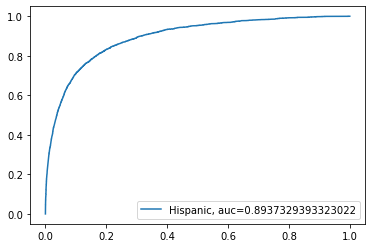

In [17]:
y_pred_proba = clf.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="Hispanic, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Jaccard Accuracy

In [18]:
metrics.accuracy_score(y_val, clf.predict(X_val))

0.9399

### 4. Explainability - proxy model drivers

In [19]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)
sv = np.array(shap_values)
y = clf.predict(X_train).astype("bool")
# shap values for high income
sv_target = sv[:,y,:]
# shap values for not high income
sv_nontarget = sv[:,~y,:]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


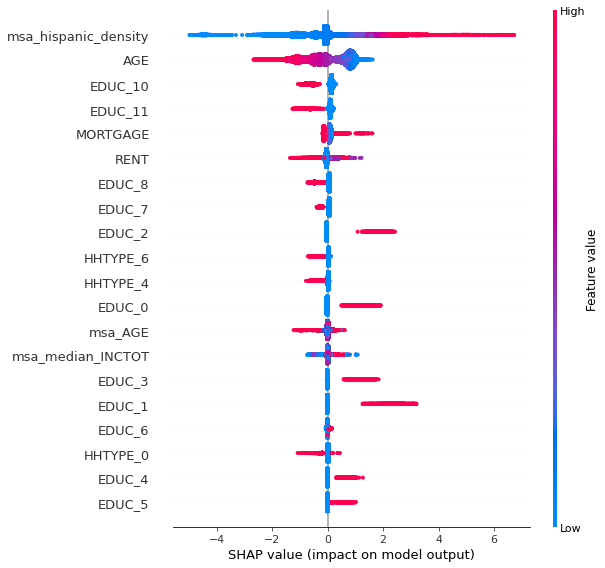

In [20]:
# Variable importance plot - how to read
# MSA_hispanic_density = percent of individuals who are hispanic in this MSA, historically
# Age = lower age, higher chance of being hispanic
# Educ 10 &11 = 4 years of college + graduate school = 1 = lower chance of being hispanic
# Income = higher = lower chance of being hispanic
shap.summary_plot(shap_values[1], X_train.astype("float"))

### Create proxy variable for Hispanic

In [21]:
# Assign a binary indicator to the highest 7.1% of model scores - these are the proxy group
pg_rate = np.percentile(clf.predict_proba(X)[::,1], 100 - 7.1)

# Count number of individauls labeled among 80K training set
# np.where(clf.predict_proba(X_train)[::,1] > pg_rate,1,0).sum()

# Perform cross-tab - accuracy is so so - 3.0 k 1,1 | 2.7 k 1,0, TPR < 70%
pd.crosstab(model_data[dependent_bin], np.where(clf.predict_proba(X)[::,1] > pg_rate,1,0)) #.apply(lambda r: r/r.sum(), axis=1)

col_0,0,1
hispanic_origin,,
0,178894,6887
1,6908,7311


### 5. Train second income - predict top 20% of income

In [37]:
# set parameters for bias check
dependent_2 = 'high_income'  # dependent variable we measure
dependent_bin_2 = 'high_income_bin'

# Positive rate
pos_rate = 0.2

In [38]:
model_input_2 = model_data.copy()

model_input_2['high_income'] = np.where(model_input_2.INCTOT > np.percentile(model_input_2.INCTOT,80),1,0)
print(model_input_2['high_income'].value_counts(normalize=True))

model_input_2['hispanic'] = model_data[dependent_bin]
model_input_2['hispanic_proxy'] = np.where(clf.predict_proba(X)[::,1] > pg_rate,1,0)

0   0.802
1   0.198
Name: high_income, dtype: float64


### Historical bias

In [39]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print(model_input_2[['hispanic_proxy', 'high_income']].groupby(['hispanic_proxy']).mean())

print(model_input_2[['hispanic', 'high_income']].groupby(['hispanic']).mean())

                high_income
hispanic_proxy             
0                     0.208
1                     0.077
          high_income
hispanic             
0               0.206
1               0.094


### 6. Run RAI analysis - hispanic actual

In [40]:
# set parameters for bias check
protected_group = 'hispanic'
protected_group_proxy = 'hispanic_proxy' 
outcome_advantage = 1
pg_disadvantage = 0 

In [41]:
y_2 = model_input_2[dependent_2]

model_input_2.drop(['high_income', 'INCTOT'], axis=1, inplace=True)

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(model_input_2,y_2,train_size=.8, random_state=42)


pg_train_2 = X_train_2[protected_group]
pg_train_proxy_2 = X_train_2[protected_group_proxy]

X_train_2.drop(['hispanic', 'hispanic_proxy'], axis=1, inplace=True)
X_val_2.drop(['hispanic', 'hispanic_proxy'], axis=1, inplace=True)

# X_train_2 = model_input_2.drop(labels=[dependent], axis=1)
# X_train_2 = X_train_2.drop(labels=['INCTOT'], axis=1)
# X_train_2 = X_train_2.drop(labels=[protected_group], axis=1)
# X_train_2 = X_train_2.drop(labels=[protected_group_proxy], axis=1)


# y_train_2 = model_input_2[dependent]

grid = {"n_estimators": [100, 200, 400],
        "max_depth": [4, 6, 8, 10]}

# Earlier model
# clf = LGBMClassifier(max_depth=3, n_estimators=1000, objective="binary")
# clf.fit(X_train,y_train, eval_set=(X_val,y_val), early_stopping_rounds=100, verbose=100) 

# Option 2 - RF
# rf_clf = RandomForestClassifier(class_weight="balanced", random_state=42)

clf_cv = GridSearchCV(clf, grid, cv=5, scoring="roc_auc", refit=True, verbose=3, n_jobs=-1)
clf_cv.fit(X_train_2, y_train_2)

best_estimator = clf_cv.best_estimator_
best_params = clf_cv.best_params_
print(best_params)

# best_estimator = RandomForestClassifier(max_depth=10, n_estimators=400, class_weight="balanced", random_state=42)
# best_estimator.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   35.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   35.7s finished


{'max_depth': 4, 'n_estimators': 200}


In [42]:
bias_ranker = ModelBiasRanker(best_estimator,
                              pos_rate= pos_rate,
                              bias_tolerance=0.2)

In [43]:
bias_ranker.fit(X_train_2, y_train_2, pg_train_2)

In [44]:
bias_ranker.results_

,Bias Test,Bias Index,Accuracy,TP,FN,TN,FP,Non PG Positive Rate,PG Positive Rate
Naive,Fail,0.174,0.831,0.634,0.366,0.855,0.145,0.117,0.020
Threshold Best,Fail,0.258,0.819,0.543,0.457,0.888,0.112,0.211,0.055
Historic Parity,Fail,0.456,0.819,0.543,0.457,0.887,0.113,0.208,0.095
Demographic Parity,Pass,1.000,0.816,0.535,0.465,0.886,0.114,0.200,0.200


### 6. Run RAI analysis - hispanic proxy

In [45]:
# y_train_2 = model_input_2[dependent]
pg_train = model_input_2[protected_group_proxy]

In [49]:
bias_ranker = ModelBiasRanker(best_estimator,
                              pos_rate=pos_rate,
                              bias_tolerance=0.2)

In [50]:
bias_ranker.fit(X_train_2, y_train_2, pg_train_proxy_2)

In [51]:
bias_ranker.results_

,Bias Test,Bias Index,Accuracy,TP,FN,TN,FP,Non PG Positive Rate,PG Positive Rate
Naive,Fail,0.048,0.831,0.634,0.366,0.855,0.145,0.118,0.006
Threshold Best,Fail,0.101,0.819,0.543,0.457,0.888,0.112,0.214,0.021
Historic Parity,Fail,0.376,0.818,0.542,0.458,0.887,0.113,0.209,0.079
Demographic Parity,Pass,1.000,0.815,0.534,0.466,0.885,0.115,0.200,0.200


### 7. Evaluate drivers of income models

In [34]:
clf_2 = LGBMClassifier(max_depth=3, n_estimators=1000, objective="binary")
clf_2.fit(X_train_2,y_train_2, eval_set=(X_val_2,y_val_2), early_stopping_rounds=100, verbose=100) 

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.38149
[200]	valid_0's binary_logloss: 0.379222
[300]	valid_0's binary_logloss: 0.378585
[400]	valid_0's binary_logloss: 0.378424
[500]	valid_0's binary_logloss: 0.378399
Early stopping, best iteration is:
[409]	valid_0's binary_logloss: 0.378339


LGBMClassifier(max_depth=3, n_estimators=1000, objective='binary')

In [35]:
explainer_2 = shap.TreeExplainer(clf_2)
shap_values_2 = explainer_2.shap_values(X_train_2)
sv_2 = np.array(shap_values_2)
y_2 = clf_2.predict(X_train_2).astype("bool")
# shap values for high income
sv_target_2 = sv_2[:,y_2,:]
# shap values for not high income
sv_nontarget_2 = sv_2[:,~y_2,:]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


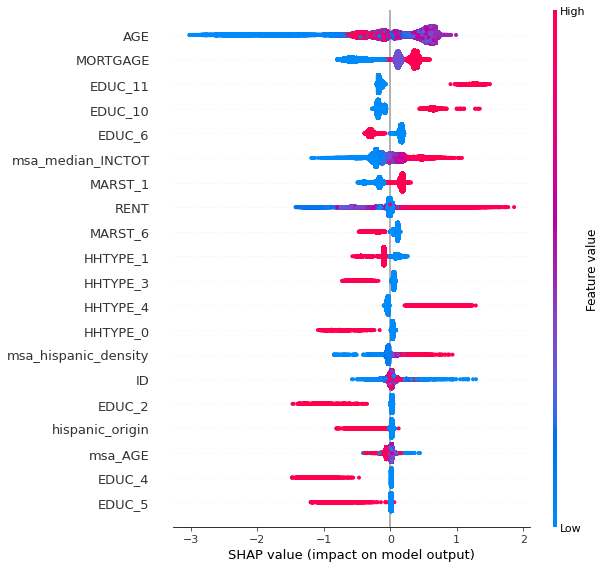

In [36]:
# Variable importance plot - how to read
shap.summary_plot(shap_values_2[1], X_train_2.astype("float"))